In [ ]:
# 环境自检：PyTorch + CUDA
import torch, platform, os, sys, subprocess, datetime
print(f"[时间] {datetime.datetime.now()}")
print(f"[Python] {sys.version.split()[0]}  ({platform.platform()})")
print(f"[Torch]  {torch.__version__}")
print(f"[CUDA]   可用 = {torch.cuda.is_available()} | 版本 = {torch.version.cuda}")
if torch.cuda.is_available():
    gpu = torch.cuda.get_device_properties(0)
    print(f"[GPU]    {gpu.name}  显存 {gpu.total_memory/1024**3:.1f} GB")

# 简单张量运算，验证 GPU 能跑 FP16
if torch.cuda.is_available():
    x = torch.randn(8_000_000, device="cuda", dtype=torch.float16)
    y = x * 2 + 1
    print("Tensor OK ‼️  均值:", y.mean().item())
else:
    print("⚠️ 没检测到 GPU，检查显卡驱动 / CUDA Toolkit")


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch, os

# 如果你之前 `setx HF_HOME D:\hf_cache`，下面不需要额外指定 cache_dir；
# 否则手动加 cache_dir="D:/hf_cache"
model_id = "Qwen/Qwen2.5-0.5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",         # 自动把 0.5B 丢到 GPU 0
    trust_remote_code=True
)

prompt = "请用一句话告诉我 PromptCBLUE 数据集是做什么的？"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
gen_ids = model.generate(**inputs, max_new_tokens=64, do_sample=False)
print(tokenizer.decode(gen_ids[0, inputs['input_ids'].shape[1]:], skip_special_tokens=True))


In [ ]:
# === LoRA fine-tune Qwen-0.5B with BF16 ===
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForCausalLM,
                          TrainingArguments, Trainer,
                          DataCollatorForLanguageModeling)
from peft import LoraConfig, get_peft_model
import torch, os

# 0) 基座模型（一次就够，如果上面已经加载就复用）
model_id = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,     # *** 关键：直接用 BF16 权重 ***
    device_map="auto",
    trust_remote_code=True
)

# 1) 读数据并拼 Prompt
def concat(example):
    example["text"] = example["instruction"] + "\n" + example["input"] + "\n" + example["output"]
    return example

raw_ds = load_dataset(
    "json",
    data_files={
        "train":"./processed/train_top_task.jsonl",
        "validation":"./processed/dev_converted.jsonl"
    }
).map(concat)

# 2) Tokenize -> ids
def tok_fn(batch):
    return tokenizer(batch["text"], truncation=True, max_length=1024)
tok_ds = raw_ds.map(tok_fn, batched=True, remove_columns=raw_ds["train"].column_names)
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# 3) LoRA 适配器
lora_cfg = LoraConfig(
    r=8, lora_alpha=16, target_modules=["q_proj","k_proj","v_proj","o_proj"],
    lora_dropout=0.05, bias="none", task_type="CAUSAL_LM"
)
model = get_peft_model(base_model, lora_cfg)

# 4) 训练参数 —— 用 bf16，关闭 fp16
args = TrainingArguments(
    output_dir="lora_ckpt",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    learning_rate=2e-4,
    bf16=True,                # ⭐ 开启 BF16
    fp16=False,
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    optim="adamw_torch_fused"  # PyTorch 自带 fused AdamW，更稳
)

# 5) Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tok_ds["train"],
    eval_dataset=tok_ds["validation"],
    data_collator=data_collator
)
trainer.train()

# 6) 保存适配器
trainer.save_model("lora_ckpt/final")
tokenizer.save_pretrained("lora_ckpt/final")
print("✅ LoRA + BF16 训练完成，权重在 lora_ckpt/final")


In [ ]:
# === 合并 LoRA + 基座权重，得到可独立推理模型 ===
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torch, os, shutil

# 1) 路径配置
base_model_id   = "Qwen/Qwen2.5-0.5B-Instruct"   # 原始基座
lora_adapter_dir = "lora_ckpt/final"             # 训练完的 LoRA 目录
merged_dir       = "qwen05_promptcblue_merged"   # 要保存的新目录

# 2) 加载基座 & LoRA
base = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.bfloat16, 
    device_map="auto",
    trust_remote_code=True
)
model = PeftModel.from_pretrained(base, lora_adapter_dir)
print("🔄 开始合并 LoRA 权重 …")
model = model.merge_and_unload()   # ⭐ 一步到位

# 3) 保存（含 tokenizer）
os.makedirs(merged_dir, exist_ok=True)
model.save_pretrained(merged_dir)
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.save_pretrained(merged_dir)
print(f"✅ 已保存到 {merged_dir}")

# 4) （可选）快速 sanity check 推理
prompt = "患者出现咳嗽、发热、呼吸困难，应考虑哪种最可能的初步诊断？"
ids = tokenizer(prompt, return_tensors="pt").to(model.device)
out = model.generate(**ids, max_new_tokens=64)
print("🗣️ 推理结果:", tokenizer.decode(out[0, ids['input_ids'].shape[1]:], skip_special_tokens=True))


In [ ]:
# ================================================
# PromptCBLUE — SAFE 单条推理，绝不会 OOM
# ================================================
import os, json, re, gc, tqdm, torch
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_DIR  = "qwen05_promptcblue_merged"
TEST_FILE  = "./processed/test_converted.jsonl"
SAVE_PATH  = "predictions_full.jsonl"
MAX_NEW_TOK = 128

tok = AutoTokenizer.from_pretrained(MODEL_DIR, trust_remote_code=True)
tok.padding_side = "left"
tok.pad_token = tok.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_DIR,
    torch_dtype=torch.bfloat16,     # bf16 占用低且稳定
    device_map="auto",
    trust_remote_code=True
).eval()

with open(TEST_FILE, encoding="utf8") as f_in, \
     open(SAVE_PATH, "w", encoding="utf8") as f_out, \
     torch.no_grad():
    
    for line in tqdm.tqdm(f_in, total=sum(1 for _ in open(TEST_FILE, encoding="utf8")), desc="Gen"):
        j = json.loads(line)
        
        prompt = j["instruction"] + "\n" + j["input"]
        toks   = tok(prompt, return_tensors="pt").to(model.device)

        out_ids= model.generate(**toks, max_new_tokens=MAX_NEW_TOK)
        ans    = tok.decode(out_ids[0, toks["input_ids"].shape[1]:],
                            skip_special_tokens=True).strip()
        ans    = re.sub(r"^(好的[,，]?\s*|答[:：]?\s*)", "", ans)  # 去客套前缀

        f_out.write(json.dumps({"id": j["id"], "prediction": ans},
                               ensure_ascii=False) + "\n")
        
        # 立即释放本条显存，防碎片
        torch.cuda.empty_cache(); gc.collect()

print(f"✅ 全量预测已写入 {SAVE_PATH}")


In [ ]:
# ==========================================================
# PromptCBLUE 预测 — OOM-SAFE + GPU 吞吐最大化  (batch=8→1)
# ==========================================================
import os, json, re, gc, tqdm, torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

# -------- 基本配置 --------
MODEL_DIR   = "qwen05_promptcblue_merged"          # 合并权重目录
TEST_FILE   = "./processed/test_converted.jsonl"
SAVE_PATH   = "predictions_full.jsonl"
BATCH_START = 64           # 起步 batch；显存吃紧会自动减半
MAX_NEW_TOK = 128         # 必要时调大 (诊疗报告 256)

# -------- 环境微调 --------
torch.backends.cuda.matmul.allow_tf32 = True       # 速度小提
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# -------- 模型 & tokenizer --------
tok  = AutoTokenizer.from_pretrained(MODEL_DIR, trust_remote_code=True)
tok.padding_side, tok.pad_token = "left", tok.eos_token
model = AutoModelForCausalLM.from_pretrained(
    MODEL_DIR,
    torch_dtype=torch.bfloat16, device_map="auto",
    trust_remote_code=True
).eval()

# -------- 数据集按长度排序，减少 padding --------
ds = load_dataset("json", data_files={"test": TEST_FILE})["test"]
sorted_idx = sorted(range(len(ds)), key=lambda i: len(ds[i]["instruction"]) + len(ds[i]["input"]))
ds = ds.select(sorted_idx)

def to_list(start, bs):
    """把 Dataset 分片转成 List[dict]（确保索引合法）"""
    sub = ds.select(range(start, min(start+bs, len(ds))))
    return [sub[i] for i in range(len(sub))]

def encode(batch):
    prompts = [b["instruction"] + "\n" + b["input"] for b in batch]
    return tok(prompts, padding=True, return_tensors="pt").to(model.device)

def clean(ans: str) -> str:
    ans = ans.strip()
    ans = re.sub(r"^(好的[,，]?\s*|答[:：]?\s*)", "", ans)
    return ans

# -------- 推理主循环 --------
curr_bs, i = BATCH_START, 0
with open(SAVE_PATH, "w", encoding="utf8") as fout, torch.no_grad():
    pbar = tqdm.tqdm(total=len(ds), desc="Generating")
    while i < len(ds):
        batch = to_list(i, curr_bs)
        try:
            toks  = encode(batch)
            outs  = model.generate(**toks, max_new_tokens=MAX_NEW_TOK)
            for sid, out in zip([b["id"] for b in batch], outs):
                pred = clean(tok.decode(out[toks["input_ids"].shape[1]:], skip_special_tokens=True))
                fout.write(json.dumps({"id": sid, "prediction": pred}, ensure_ascii=False) + "\n")
            i += curr_bs
            pbar.update(curr_bs)
            torch.cuda.empty_cache(); gc.collect()
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                torch.cuda.empty_cache(); gc.collect()
                curr_bs //= 2
                if curr_bs == 0:
                    raise RuntimeError("显存仍不足，已降至 batch=1 仍 OOM") from e
                print(f"⚠️  OOM → batch_size 调至 {curr_bs}")
            else:
                raise e
    pbar.close()

print(f"✅ 预测完成 → {SAVE_PATH}")


In [ ]:
import os, json, re, gc, tqdm, torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_DIR  = "qwen05_promptcblue_merged"
TEST_FILE  = "./processed/test_converted.jsonl"
SAVE_PATH  = "predictions_full.jsonl"
MAX_NEW_TOK = 128
BATCH_INIT  = 64          # 起步 batch
MIN_BATCH   = 1          # 不再往下减时的底线

# ---------- tokenizer & model ----------
tok = AutoTokenizer.from_pretrained(MODEL_DIR, trust_remote_code=True)
tok.padding_side, tok.pad_token = "left", tok.eos_token
model = AutoModelForCausalLM.from_pretrained(
    MODEL_DIR, torch_dtype=torch.bfloat16, device_map="auto",
    trust_remote_code=True).eval()

# ---------- 数据 ----------
ds = load_dataset("json", data_files={"test": TEST_FILE})["test"]
sorted_idx = sorted(range(len(ds)), key=lambda i: len(ds[i]["instruction"]) + len(ds[i]["input"]))
ds = ds.select(sorted_idx)

# ---------- 读取已完成 ID，跳过 ----------
done_ids = set()
if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, encoding="utf8") as f:
        for l in f:
            done_ids.add(json.loads(l)["id"])
print(f"已完成 {len(done_ids)} / {len(ds)} 条，继续生成…")

def encode(batch):
    prompts = [b["instruction"] + "\n" + b["input"] for b in batch]
    return tok(prompts, padding=True, return_tensors="pt").to(model.device)

def clean(ans):
    return re.sub(r"^(好的[,，]?\s*|答[:：]?\s*)", "", ans.strip())

curr_bs = BATCH_INIT
i = 0
with open(SAVE_PATH, "a", encoding="utf8") as fout, torch.no_grad():
    pbar = tqdm.tqdm(total=len(ds) - len(done_ids), desc="Resume-Gen")
    while i < len(ds):
        # 跳过已完成
        if ds[i]["id"] in done_ids:
            i += 1
            continue
        # 准备 batch（只拿未完成样本）
        batch, j = [], i
        while j < len(ds) and len(batch) < curr_bs:
            if ds[j]["id"] not in done_ids:
                batch.append(ds[j])
            j += 1
        try:
            toks = encode(batch)
            outs = model.generate(**toks, max_new_tokens=MAX_NEW_TOK)
            for sid, out in zip([b["id"] for b in batch], outs):
                fout.write(json.dumps({"id": sid,
                                       "prediction": clean(tok.decode(out[toks["input_ids"].shape[1]:],
                                                                      skip_special_tokens=True))},
                                      ensure_ascii=False) + "\n")
                done_ids.add(sid)
                pbar.update(1)
            i = j
            torch.cuda.empty_cache(); gc.collect()
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                torch.cuda.empty_cache(); gc.collect()
                curr_bs = max(MIN_BATCH, curr_bs // 2)   # 正确减半
                print(f"⚠️  OOM！batch_size 降到 {curr_bs}")
                if curr_bs == MIN_BATCH:
                    print("仍然 OOM？考虑把 MAX_NEW_TOK 调低再跑。")
            else:
                raise e
    pbar.close()

print("🎉 预测完成！文件已写入", SAVE_PATH)


In [ ]:
import json, subprocess, sys, os, tqdm

TEST_FILE = "./processed/test_converted.jsonl"
RAW_PRED  = "predictions_full.jsonl"
FIX_PRED  = "predictions_fixed.jsonl"
DEFAULT_ANSWER = "无法确定"          # 给缺失样本的占位答案，可自定义

# 1️⃣ 读取已有预测
pred_dict = {}
with open(RAW_PRED, encoding="utf8") as f:
    for line in f:
        obj = json.loads(line)
        pred_dict[obj["id"]] = obj["prediction"]

print("原预测条数:", len(pred_dict))

# 2️⃣ 遍历测试集，补缺并写新文件
with open(TEST_FILE, encoding="utf8") as fin, \
     open(FIX_PRED,  "w", encoding="utf8") as fout:
    for line in tqdm.tqdm(fin, desc="Writing fixed"):
        sample = json.loads(line)
        sid = sample["id"]
        ans = pred_dict.get(sid, DEFAULT_ANSWER)
        fout.write(json.dumps({"id": sid, "prediction": ans},
                              ensure_ascii=False) + "\n")

print("修补完成 → 新文件:", FIX_PRED)



In [ ]:
#要评分了，我的回复是predictions_fixed，现在要和官方正确标准比较，拿到分数

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# ==== ✅ 第一步：加载合并模型和分词器 ====
merged_model_path = "qwen05_promptcblue_merged"  # 你保存的合并模型目录
tokenizer = AutoTokenizer.from_pretrained(merged_model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    merged_model_path,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)
model.eval()



In [ ]:

# ==== ✏️ 第二步：填写你的输入（模拟医生问诊场景） ====
your_input = """
"糖尿病的病因是啥"
"""

outputs = model.generate(
    **tokenizer(your_input, return_tensors="pt").to(model.device),
    max_new_tokens=64,
    do_sample=False,
    top_p=0.9,
    repetition_penalty=1.2,       # 🔒 避免复读关键
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id
)

response = tokenizer.decode(outputs[0], skip_special_tokens=True)


print("🤖 医生回复：", response.strip())


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# 加载原生 Qwen 模型（无LoRA）
base_model_id = "Qwen/Qwen2-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)
model.eval()


In [ ]:

# 输入 prompt
your_input = """你是医生，
### 病人：讲一下糖尿病的病因？
医生："""

# 生成响应
inputs = tokenizer(your_input, return_tensors="pt").to(model.device)
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=64,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        repetition_penalty=1.2,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )

response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
for stop_word in ["患者：", "病人：", "Human:", "\n\n"]:
    if stop_word in response:
        response = response.split(stop_word)[0]
print("🧠 原生 Qwen 回复：", response.strip())


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# === 1. 加载合并后的 Qwen 模型 ===
merged_model_path = "qwen05_promptcblue_merged"  # 修改为你保存模型的位置
tokenizer = AutoTokenizer.from_pretrained(merged_model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    merged_model_path,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)
model.eval()

# === 2. 定义 PromptCBLUE 多任务测试输入 ===
prompts = [
    ("CMeEE-V2", "请识别下面句子中的医学实体及类型。\n\n句子：患者出现剧烈咳嗽，面色苍白，伴随头晕和心悸。"),
    ("CMeIE", "请抽取句子中的医学关系三元组。\n\n句子：心力衰竭可使用伊伐布雷治疗。"),
    ("CHIP-CDN", "请将下面句子中提到的疾病或症状进行标准化。\n\n句子：患者疑似十二指肠交界性肿瘤及管状腺瘤。"),
    ("CHIP-CDEE", "请抽取下面句子中的医学事件信息（主体词、修饰词、解剖部位等）。\n\n句子：患者腹痛、腹胀、恶心，伴有发热和头昏。"),
    ("IMCS-V2-NER", "请标注以下句子中的医学实体及类型。\n\n句子：血常规提示白细胞升高，考虑病毒感染。"),
    ("CHIP-MDCFNPC", "请判断下面描述中患者可能患有哪些疾病。\n\n描述：患者最近出现腹泻、水样便、肛门疼痛。"),
    ("CHIP-STS", "判断下面两句话是否语义相似。\n\n句1：我最近咳嗽得厉害。\n句2：我老是咳嗽。"),
    ("KUAKE-QIC", "请判断下面的问题属于哪一类。\n\n问题：请问尿蛋白1+严重吗？"),
    ("MedDG", "医生你好，我肚子疼。你觉得什么原因？"),
    ("IMCS-V2-MRG", "请生成主诉、现病史、诊断和建议：\n\n描述：小孩腹泻两天，大便次数增多。")
]

# === 3. 批量推理并展示结果 ===
for task_name, prompt in prompts:
    print(f"=== [{task_name}] ===")
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=True, temperature=0.7,
            eos_token_id=tokenizer.eos_token_id
        )
    answer = tokenizer.decode(outputs[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
    print(f"📝 Prompt:\n{prompt}")
    print(f"🤖 模型回复:\n{answer}\n{'-'*80}")


In [ ]:
import json
from collections import Counter, defaultdict

raw_path = "./processed/train_converted.jsonl"
filtered_path = "./processed/train_top_task.jsonl"

# 1) 统计每种 instruction 出现次数
instr_counter = Counter()
samples_by_instr = defaultdict(list)

with open(raw_path, "r", encoding="utf-8") as f:
    for line in f:
        sample = json.loads(line)
        instr = sample.get("instruction", "").strip()
        instr_counter[instr] += 1
        samples_by_instr[instr].append(sample)

# 2) 找到出现次数最多的 instruction
top_instr, top_count = instr_counter.most_common(1)[0]
top_samples = samples_by_instr[top_instr]

print(f"最常见 instruction:\n{top_instr}\n出现次数: {top_count}")

# 3) 将对应样本写入新 jsonl
with open(filtered_path, "w", encoding="utf-8") as f:
    for s in top_samples:
        f.write(json.dumps(s, ensure_ascii=False) + "\n")

print(f"\n已将 {len(top_samples)} 条样本保存到 {filtered_path}")


In [ ]:
import json

# 代码 Cell：从 dev_converted.jsonl 中提取指定任务并保存为 dev_top_task.jsonl
input_file = './processed/dev_converted.jsonl'
output_file = './processed/dev_top_task.jsonl'

count = 0
with open(input_file, 'r', encoding='utf-8') as fin, open(output_file, 'w', encoding='utf-8') as fout:
    for line in fin:
        obj = json.loads(line)
        if obj.get('instruction', '').startswith(
            "根据给定内容，判断列出的临床发现实体是阳性、阴性、其他还是不标注。"
        ):
            fout.write(json.dumps(obj, ensure_ascii=False) + "\n")
            count += 1

print(f"Filtered {count} records into {output_file}")


In [ ]:
# === LoRA fine-tune Qwen-0.5B with BF16, real-time loss plotting, CSV logging, and save-on-terminate ===

import os
import csv
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    TrainingArguments, Trainer, TrainerCallback,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model

# ─── 0) Setup ────────────────────────────────────────────────────────────────
output_dir = "lora_ckpt"
os.makedirs(output_dir, exist_ok=True)

model_id = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)

# ─── 1) Prepare Data ─────────────────────────────────────────────────────────
def concat(example):
    example["text"] = example["instruction"] + "\n" + example["input"] + "\n" + example["output"]
    return example

raw_ds = load_dataset(
    "json",
    data_files={
        "train": "./processed/train_top_task.jsonl",
        "validation": "./processed/dev_top_task.jsonl"
    }
).map(concat)

def tok_fn(batch):
    return tokenizer(batch["text"], truncation=True, max_length=1024)

tok_ds = raw_ds.map(tok_fn, batched=True, remove_columns=raw_ds["train"].column_names)
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# ─── 2) LoRA Adapter ─────────────────────────────────────────────────────────
lora_cfg = LoraConfig(
    r=8, lora_alpha=16,
    target_modules=["q_proj","k_proj","v_proj","o_proj"],
    lora_dropout=0.05, bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(base_model, lora_cfg)

# ─── 3) Callback for Loss Logging & Plotting ─────────────────────────────────
class LossCallback(TrainerCallback):
    def __init__(self, csv_path):
        # Prepare CSV
        self.csv_file = open(csv_path, 'w', newline='', encoding='utf-8')
        self.csv_writer = csv.writer(self.csv_file)
        self.csv_writer.writerow(['step', 'loss'])
        # Prepare plot
        plt.ion()
        self.fig, self.ax = plt.subplots()
        self.line, = self.ax.plot([], [], lw=2)
        self.ax.set_xlabel('Step')
        self.ax.set_ylabel('Loss')
        self.ax.set_title('Training Loss')
        self.steps, self.losses = [], []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            step = state.global_step
            loss = logs["loss"]
            self.steps.append(step)
            self.losses.append(loss)
            # write to CSV
            self.csv_writer.writerow([step, loss])
            self.csv_file.flush()
            # update plot
            self.line.set_data(self.steps, self.losses)
            self.ax.relim()
            self.ax.autoscale_view()
            self.fig.canvas.draw()
            self.fig.canvas.flush_events()

    def on_train_end(self, args, state, control, **kwargs):
        self.csv_file.close()
        plt.ioff()
        plt.show()

loss_cb = LossCallback(csv_path=os.path.join(output_dir, "loss.csv"))

# ─── 4) Training Arguments ───────────────────────────────────────────────────
args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    learning_rate=2e-4,
    bf16=True,
    fp16=False,
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    optim="adamw_torch_fused"
)

# ─── 5) Trainer Init ─────────────────────────────────────────────────────────
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tok_ds["train"],
    eval_dataset=tok_ds["validation"],
    data_collator=data_collator,
    callbacks=[loss_cb]
)

# ─── 6) Train with Interrupt Handling ────────────────────────────────────────
try:
    trainer.train()
except KeyboardInterrupt:
    print("⚠️ Training interrupted. Saving current adapter and tokenizer...")
    trainer.save_model(os.path.join(output_dir, "interrupted"))
    tokenizer.save_pretrained(os.path.join(output_dir, "interrupted"))
finally:
    print("✅ Training finished. Artifacts and loss logs are in:", output_dir)


d:\Anaconda\envs\qwen05_lora\lib\site-packages\transformers\utils\hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
d:\Anaconda\envs\qwen05_lora\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/936 [00:00<?, ?it/s]

d:\Anaconda\envs\qwen05_lora\lib\site-packages\transformers\models\qwen2\modeling_qwen2.py:693: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 2.9107, 'grad_norm': 1.71875, 'learning_rate': 0.00019786324786324788, 'epoch': 0.03}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.735177516937256, 'eval_runtime': 187.3612, 'eval_samples_per_second': 4.27, 'eval_steps_per_second': 0.534, 'epoch': 0.03}
{'loss': 1.8781, 'grad_norm': 2.25, 'learning_rate': 0.00019572649572649573, 'epoch': 0.06}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.5323009490966797, 'eval_runtime': 186.7719, 'eval_samples_per_second': 4.283, 'eval_steps_per_second': 0.535, 'epoch': 0.06}
{'loss': 1.2013, 'grad_norm': 1.1640625, 'learning_rate': 0.0001935897435897436, 'epoch': 0.1}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.538970708847046, 'eval_runtime': 186.5812, 'eval_samples_per_second': 4.288, 'eval_steps_per_second': 0.536, 'epoch': 0.1}
{'loss': 0.9408, 'grad_norm': 1.2578125, 'learning_rate': 0.00019145299145299148, 'epoch': 0.13}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.5759494304656982, 'eval_runtime': 186.7406, 'eval_samples_per_second': 4.284, 'eval_steps_per_second': 0.536, 'epoch': 0.13}
{'loss': 0.9613, 'grad_norm': 0.8203125, 'learning_rate': 0.00018931623931623933, 'epoch': 0.16}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.6332669258117676, 'eval_runtime': 186.6771, 'eval_samples_per_second': 4.285, 'eval_steps_per_second': 0.536, 'epoch': 0.16}
{'loss': 0.8357, 'grad_norm': 0.75, 'learning_rate': 0.0001871794871794872, 'epoch': 0.19}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.6640784740448, 'eval_runtime': 186.8481, 'eval_samples_per_second': 4.282, 'eval_steps_per_second': 0.535, 'epoch': 0.19}
{'loss': 0.898, 'grad_norm': 0.921875, 'learning_rate': 0.00018504273504273505, 'epoch': 0.22}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.705317497253418, 'eval_runtime': 186.2823, 'eval_samples_per_second': 4.295, 'eval_steps_per_second': 0.537, 'epoch': 0.22}
{'loss': 0.8569, 'grad_norm': 0.70703125, 'learning_rate': 0.00018290598290598292, 'epoch': 0.26}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7448487281799316, 'eval_runtime': 186.6816, 'eval_samples_per_second': 4.285, 'eval_steps_per_second': 0.536, 'epoch': 0.26}
{'loss': 0.8168, 'grad_norm': 0.68359375, 'learning_rate': 0.00018076923076923077, 'epoch': 0.29}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.687802791595459, 'eval_runtime': 186.6158, 'eval_samples_per_second': 4.287, 'eval_steps_per_second': 0.536, 'epoch': 0.29}
{'loss': 0.8639, 'grad_norm': 0.62109375, 'learning_rate': 0.00017863247863247864, 'epoch': 0.32}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7188711166381836, 'eval_runtime': 186.5305, 'eval_samples_per_second': 4.289, 'eval_steps_per_second': 0.536, 'epoch': 0.32}


d:\Anaconda\envs\qwen05_lora\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.8479, 'grad_norm': 0.53515625, 'learning_rate': 0.0001764957264957265, 'epoch': 0.35}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.735438346862793, 'eval_runtime': 186.7905, 'eval_samples_per_second': 4.283, 'eval_steps_per_second': 0.535, 'epoch': 0.35}
{'loss': 0.8449, 'grad_norm': 0.5703125, 'learning_rate': 0.00017435897435897436, 'epoch': 0.38}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7648589611053467, 'eval_runtime': 186.744, 'eval_samples_per_second': 4.284, 'eval_steps_per_second': 0.535, 'epoch': 0.38}
{'loss': 0.8207, 'grad_norm': 0.61328125, 'learning_rate': 0.00017222222222222224, 'epoch': 0.42}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7146999835968018, 'eval_runtime': 186.8528, 'eval_samples_per_second': 4.281, 'eval_steps_per_second': 0.535, 'epoch': 0.42}
{'loss': 0.7931, 'grad_norm': 0.62109375, 'learning_rate': 0.00017008547008547008, 'epoch': 0.45}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7718944549560547, 'eval_runtime': 186.6242, 'eval_samples_per_second': 4.287, 'eval_steps_per_second': 0.536, 'epoch': 0.45}
{'loss': 0.7273, 'grad_norm': 0.58984375, 'learning_rate': 0.00016794871794871796, 'epoch': 0.48}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7787740230560303, 'eval_runtime': 186.775, 'eval_samples_per_second': 4.283, 'eval_steps_per_second': 0.535, 'epoch': 0.48}


d:\Anaconda\envs\qwen05_lora\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.8334, 'grad_norm': 0.56640625, 'learning_rate': 0.00016581196581196583, 'epoch': 0.51}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.773144483566284, 'eval_runtime': 186.4368, 'eval_samples_per_second': 4.291, 'eval_steps_per_second': 0.536, 'epoch': 0.51}
{'loss': 0.7739, 'grad_norm': 0.44140625, 'learning_rate': 0.00016367521367521368, 'epoch': 0.54}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7180967330932617, 'eval_runtime': 186.7085, 'eval_samples_per_second': 4.285, 'eval_steps_per_second': 0.536, 'epoch': 0.54}
{'loss': 0.8224, 'grad_norm': 0.451171875, 'learning_rate': 0.00016153846153846155, 'epoch': 0.58}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7706716060638428, 'eval_runtime': 186.3628, 'eval_samples_per_second': 4.293, 'eval_steps_per_second': 0.537, 'epoch': 0.58}
{'loss': 0.8268, 'grad_norm': 0.5078125, 'learning_rate': 0.00015940170940170943, 'epoch': 0.61}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.8255133628845215, 'eval_runtime': 186.4132, 'eval_samples_per_second': 4.292, 'eval_steps_per_second': 0.536, 'epoch': 0.61}
{'loss': 0.8068, 'grad_norm': 0.5703125, 'learning_rate': 0.00015726495726495727, 'epoch': 0.64}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.766544818878174, 'eval_runtime': 186.7523, 'eval_samples_per_second': 4.284, 'eval_steps_per_second': 0.535, 'epoch': 0.64}


d:\Anaconda\envs\qwen05_lora\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.8159, 'grad_norm': 0.50390625, 'learning_rate': 0.00015512820512820515, 'epoch': 0.67}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.761665105819702, 'eval_runtime': 186.6988, 'eval_samples_per_second': 4.285, 'eval_steps_per_second': 0.536, 'epoch': 0.67}
{'loss': 0.7404, 'grad_norm': 0.53125, 'learning_rate': 0.000152991452991453, 'epoch': 0.7}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7524895668029785, 'eval_runtime': 186.7093, 'eval_samples_per_second': 4.285, 'eval_steps_per_second': 0.536, 'epoch': 0.7}
{'loss': 0.7716, 'grad_norm': 0.49609375, 'learning_rate': 0.00015085470085470087, 'epoch': 0.74}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.782177448272705, 'eval_runtime': 186.6705, 'eval_samples_per_second': 4.286, 'eval_steps_per_second': 0.536, 'epoch': 0.74}
{'loss': 0.7793, 'grad_norm': 0.59375, 'learning_rate': 0.00014871794871794872, 'epoch': 0.77}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.758836030960083, 'eval_runtime': 186.481, 'eval_samples_per_second': 4.29, 'eval_steps_per_second': 0.536, 'epoch': 0.77}
{'loss': 0.8199, 'grad_norm': 0.48046875, 'learning_rate': 0.0001465811965811966, 'epoch': 0.8}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7495827674865723, 'eval_runtime': 186.7246, 'eval_samples_per_second': 4.284, 'eval_steps_per_second': 0.536, 'epoch': 0.8}


d:\Anaconda\envs\qwen05_lora\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.7212, 'grad_norm': 0.490234375, 'learning_rate': 0.00014444444444444444, 'epoch': 0.83}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7804272174835205, 'eval_runtime': 186.3579, 'eval_samples_per_second': 4.293, 'eval_steps_per_second': 0.537, 'epoch': 0.83}
{'loss': 0.7921, 'grad_norm': 0.482421875, 'learning_rate': 0.0001423076923076923, 'epoch': 0.86}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.738548994064331, 'eval_runtime': 186.6649, 'eval_samples_per_second': 4.286, 'eval_steps_per_second': 0.536, 'epoch': 0.86}
{'loss': 0.7646, 'grad_norm': 0.578125, 'learning_rate': 0.00014017094017094016, 'epoch': 0.9}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.774688482284546, 'eval_runtime': 186.7072, 'eval_samples_per_second': 4.285, 'eval_steps_per_second': 0.536, 'epoch': 0.9}
{'loss': 0.7924, 'grad_norm': 0.51953125, 'learning_rate': 0.00013803418803418803, 'epoch': 0.93}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7493133544921875, 'eval_runtime': 186.8936, 'eval_samples_per_second': 4.281, 'eval_steps_per_second': 0.535, 'epoch': 0.93}
{'loss': 0.8439, 'grad_norm': 0.58203125, 'learning_rate': 0.0001358974358974359, 'epoch': 0.96}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.756263494491577, 'eval_runtime': 186.3636, 'eval_samples_per_second': 4.293, 'eval_steps_per_second': 0.537, 'epoch': 0.96}


d:\Anaconda\envs\qwen05_lora\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.7677, 'grad_norm': 0.56640625, 'learning_rate': 0.00013376068376068375, 'epoch': 0.99}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.787390947341919, 'eval_runtime': 186.5364, 'eval_samples_per_second': 4.289, 'eval_steps_per_second': 0.536, 'epoch': 0.99}
{'loss': 0.786, 'grad_norm': 0.47265625, 'learning_rate': 0.00013162393162393163, 'epoch': 1.02}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.762009859085083, 'eval_runtime': 186.4123, 'eval_samples_per_second': 4.292, 'eval_steps_per_second': 0.536, 'epoch': 1.02}
{'loss': 0.7814, 'grad_norm': 0.55859375, 'learning_rate': 0.0001294871794871795, 'epoch': 1.06}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.797741174697876, 'eval_runtime': 186.8079, 'eval_samples_per_second': 4.282, 'eval_steps_per_second': 0.535, 'epoch': 1.06}
{'loss': 0.7769, 'grad_norm': 0.6953125, 'learning_rate': 0.00012735042735042735, 'epoch': 1.09}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7983739376068115, 'eval_runtime': 186.7691, 'eval_samples_per_second': 4.283, 'eval_steps_per_second': 0.535, 'epoch': 1.09}
{'loss': 0.7823, 'grad_norm': 0.5859375, 'learning_rate': 0.00012521367521367522, 'epoch': 1.12}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7533841133117676, 'eval_runtime': 186.6762, 'eval_samples_per_second': 4.285, 'eval_steps_per_second': 0.536, 'epoch': 1.12}


d:\Anaconda\envs\qwen05_lora\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.7323, 'grad_norm': 0.515625, 'learning_rate': 0.0001230769230769231, 'epoch': 1.15}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.809715986251831, 'eval_runtime': 186.684, 'eval_samples_per_second': 4.285, 'eval_steps_per_second': 0.536, 'epoch': 1.15}
{'loss': 0.783, 'grad_norm': 0.5703125, 'learning_rate': 0.00012094017094017094, 'epoch': 1.18}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7659966945648193, 'eval_runtime': 186.7962, 'eval_samples_per_second': 4.283, 'eval_steps_per_second': 0.535, 'epoch': 1.18}
{'loss': 0.7701, 'grad_norm': 0.5, 'learning_rate': 0.0001188034188034188, 'epoch': 1.22}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7735137939453125, 'eval_runtime': 186.315, 'eval_samples_per_second': 4.294, 'eval_steps_per_second': 0.537, 'epoch': 1.22}
{'loss': 0.7415, 'grad_norm': 0.578125, 'learning_rate': 0.00011666666666666668, 'epoch': 1.25}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.8284246921539307, 'eval_runtime': 186.7429, 'eval_samples_per_second': 4.284, 'eval_steps_per_second': 0.535, 'epoch': 1.25}
{'loss': 0.7722, 'grad_norm': 0.5234375, 'learning_rate': 0.00011452991452991453, 'epoch': 1.28}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.817128896713257, 'eval_runtime': 186.3148, 'eval_samples_per_second': 4.294, 'eval_steps_per_second': 0.537, 'epoch': 1.28}


d:\Anaconda\envs\qwen05_lora\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.7603, 'grad_norm': 0.484375, 'learning_rate': 0.0001123931623931624, 'epoch': 1.31}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7782318592071533, 'eval_runtime': 186.3396, 'eval_samples_per_second': 4.293, 'eval_steps_per_second': 0.537, 'epoch': 1.31}
{'loss': 0.7973, 'grad_norm': 0.5625, 'learning_rate': 0.00011025641025641027, 'epoch': 1.34}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7732274532318115, 'eval_runtime': 186.7442, 'eval_samples_per_second': 4.284, 'eval_steps_per_second': 0.535, 'epoch': 1.34}
{'loss': 0.7922, 'grad_norm': 0.5390625, 'learning_rate': 0.00010811965811965812, 'epoch': 1.38}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.788694143295288, 'eval_runtime': 186.7546, 'eval_samples_per_second': 4.284, 'eval_steps_per_second': 0.535, 'epoch': 1.38}
{'loss': 0.7502, 'grad_norm': 0.51953125, 'learning_rate': 0.000105982905982906, 'epoch': 1.41}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.790432929992676, 'eval_runtime': 186.7569, 'eval_samples_per_second': 4.284, 'eval_steps_per_second': 0.535, 'epoch': 1.41}
{'loss': 0.8175, 'grad_norm': 0.515625, 'learning_rate': 0.00010384615384615386, 'epoch': 1.44}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.766448974609375, 'eval_runtime': 186.3294, 'eval_samples_per_second': 4.293, 'eval_steps_per_second': 0.537, 'epoch': 1.44}


d:\Anaconda\envs\qwen05_lora\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.8247, 'grad_norm': 0.51953125, 'learning_rate': 0.0001017094017094017, 'epoch': 1.47}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.8005406856536865, 'eval_runtime': 186.7484, 'eval_samples_per_second': 4.284, 'eval_steps_per_second': 0.535, 'epoch': 1.47}
{'loss': 0.7404, 'grad_norm': 0.609375, 'learning_rate': 9.957264957264958e-05, 'epoch': 1.5}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7964980602264404, 'eval_runtime': 186.7933, 'eval_samples_per_second': 4.283, 'eval_steps_per_second': 0.535, 'epoch': 1.5}
{'loss': 0.7168, 'grad_norm': 0.498046875, 'learning_rate': 9.743589743589744e-05, 'epoch': 1.54}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.799997568130493, 'eval_runtime': 186.4422, 'eval_samples_per_second': 4.291, 'eval_steps_per_second': 0.536, 'epoch': 1.54}
{'loss': 0.7823, 'grad_norm': 0.49609375, 'learning_rate': 9.52991452991453e-05, 'epoch': 1.57}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.8017852306365967, 'eval_runtime': 186.7516, 'eval_samples_per_second': 4.284, 'eval_steps_per_second': 0.535, 'epoch': 1.57}
{'loss': 0.7768, 'grad_norm': 0.5859375, 'learning_rate': 9.316239316239317e-05, 'epoch': 1.6}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.8386521339416504, 'eval_runtime': 186.7496, 'eval_samples_per_second': 4.284, 'eval_steps_per_second': 0.535, 'epoch': 1.6}


d:\Anaconda\envs\qwen05_lora\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.7936, 'grad_norm': 0.5234375, 'learning_rate': 9.102564102564103e-05, 'epoch': 1.63}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.810772180557251, 'eval_runtime': 186.7136, 'eval_samples_per_second': 4.285, 'eval_steps_per_second': 0.536, 'epoch': 1.63}
{'loss': 0.7243, 'grad_norm': 0.54296875, 'learning_rate': 8.888888888888889e-05, 'epoch': 1.66}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.8049535751342773, 'eval_runtime': 186.7393, 'eval_samples_per_second': 4.284, 'eval_steps_per_second': 0.536, 'epoch': 1.66}
{'loss': 0.7819, 'grad_norm': 0.498046875, 'learning_rate': 8.675213675213675e-05, 'epoch': 1.7}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.789511203765869, 'eval_runtime': 186.786, 'eval_samples_per_second': 4.283, 'eval_steps_per_second': 0.535, 'epoch': 1.7}
{'loss': 0.7916, 'grad_norm': 0.578125, 'learning_rate': 8.461538461538461e-05, 'epoch': 1.73}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.773860454559326, 'eval_runtime': 186.7738, 'eval_samples_per_second': 4.283, 'eval_steps_per_second': 0.535, 'epoch': 1.73}
{'loss': 0.8004, 'grad_norm': 0.5625, 'learning_rate': 8.247863247863247e-05, 'epoch': 1.76}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7844290733337402, 'eval_runtime': 186.7756, 'eval_samples_per_second': 4.283, 'eval_steps_per_second': 0.535, 'epoch': 1.76}


d:\Anaconda\envs\qwen05_lora\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.8128, 'grad_norm': 0.54296875, 'learning_rate': 8.034188034188035e-05, 'epoch': 1.79}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.8049683570861816, 'eval_runtime': 186.7596, 'eval_samples_per_second': 4.284, 'eval_steps_per_second': 0.535, 'epoch': 1.79}
{'loss': 0.7574, 'grad_norm': 0.55078125, 'learning_rate': 7.820512820512821e-05, 'epoch': 1.82}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.806752920150757, 'eval_runtime': 186.7021, 'eval_samples_per_second': 4.285, 'eval_steps_per_second': 0.536, 'epoch': 1.82}
{'loss': 0.7963, 'grad_norm': 0.640625, 'learning_rate': 7.606837606837607e-05, 'epoch': 1.86}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.8106603622436523, 'eval_runtime': 186.3376, 'eval_samples_per_second': 4.293, 'eval_steps_per_second': 0.537, 'epoch': 1.86}
{'loss': 0.6968, 'grad_norm': 0.5078125, 'learning_rate': 7.393162393162394e-05, 'epoch': 1.89}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.807821273803711, 'eval_runtime': 186.711, 'eval_samples_per_second': 4.285, 'eval_steps_per_second': 0.536, 'epoch': 1.89}
{'loss': 0.7693, 'grad_norm': 0.52734375, 'learning_rate': 7.17948717948718e-05, 'epoch': 1.92}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7869362831115723, 'eval_runtime': 186.8017, 'eval_samples_per_second': 4.283, 'eval_steps_per_second': 0.535, 'epoch': 1.92}


d:\Anaconda\envs\qwen05_lora\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.7566, 'grad_norm': 0.5234375, 'learning_rate': 6.965811965811965e-05, 'epoch': 1.95}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.78584361076355, 'eval_runtime': 186.3813, 'eval_samples_per_second': 4.292, 'eval_steps_per_second': 0.537, 'epoch': 1.95}
{'loss': 0.7394, 'grad_norm': 0.5, 'learning_rate': 6.752136752136753e-05, 'epoch': 1.98}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.7991693019866943, 'eval_runtime': 186.5705, 'eval_samples_per_second': 4.288, 'eval_steps_per_second': 0.536, 'epoch': 1.98}
{'loss': 0.779, 'grad_norm': 0.53125, 'learning_rate': 6.538461538461539e-05, 'epoch': 2.02}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.801422119140625, 'eval_runtime': 186.7008, 'eval_samples_per_second': 4.285, 'eval_steps_per_second': 0.536, 'epoch': 2.02}
{'loss': 0.7889, 'grad_norm': 0.53515625, 'learning_rate': 6.324786324786325e-05, 'epoch': 2.05}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.791327476501465, 'eval_runtime': 186.7566, 'eval_samples_per_second': 4.284, 'eval_steps_per_second': 0.535, 'epoch': 2.05}
{'loss': 0.7867, 'grad_norm': 0.5625, 'learning_rate': 6.111111111111112e-05, 'epoch': 2.08}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.8012540340423584, 'eval_runtime': 191.3033, 'eval_samples_per_second': 4.182, 'eval_steps_per_second': 0.523, 'epoch': 2.08}


d:\Anaconda\envs\qwen05_lora\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.7471, 'grad_norm': 0.52734375, 'learning_rate': 5.897435897435898e-05, 'epoch': 2.11}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 2.817230224609375, 'eval_runtime': 196.612, 'eval_samples_per_second': 4.069, 'eval_steps_per_second': 0.509, 'epoch': 2.11}


KeyboardInterrupt: 

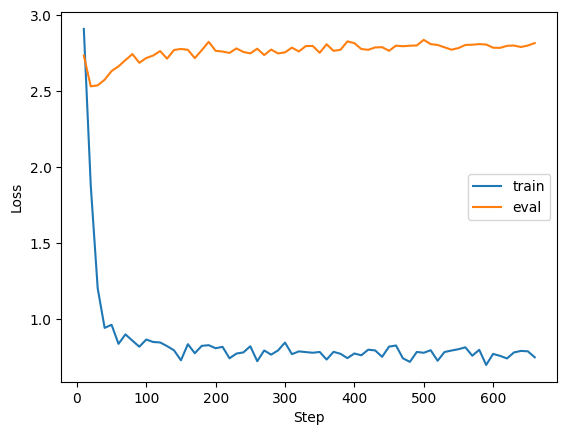

In [1]:
# === 更新：每隔 step 记录 eval loss（更小间隔），并实时画图 & 存 CSV ===

import os
import csv
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    TrainingArguments, Trainer, TrainerCallback,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model
from transformers import (
    TrainingArguments, Trainer, TrainerCallback,
    DataCollatorForLanguageModeling
)
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, get_peft_model
import os, csv, matplotlib.pyplot as plt

# 0) 输出目录
output_dir = "lora_ckpt2"
os.makedirs(output_dir, exist_ok=True)

# 1) 加载模型与 tokenizer
model_id = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
base_model = AutoModelForCausalLM.from_pretrained(
    model_id, torch_dtype="auto", device_map="auto", trust_remote_code=True
)

# 2) 数据处理（略，保持与之前相同）
def concat(ex): ex["text"] = ex["instruction"]+"\n"+ex["input"]+"\n"+ex["output"]; return ex

raw_ds = load_dataset("json",
    data_files={"train":"./processed/train_top_task.jsonl",
                "validation":"./processed/dev_top_task.jsonl"}
).map(concat)

tok_ds = raw_ds.map(lambda b: tokenizer(b["text"], truncation=True, max_length=1024),
                   batched=True, remove_columns=raw_ds["train"].column_names)
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# 3) 插入 LoRA
lora_cfg = LoraConfig(r=8, lora_alpha=16,
    target_modules=["q_proj","k_proj","v_proj","o_proj"],
    lora_dropout=0.05, bias="none", task_type="CAUSAL_LM"
)
model = get_peft_model(base_model, lora_cfg)

# 4) Callback：同时记录 train/eval loss
class LossCallback(TrainerCallback):
    def __init__(self, csv_path):
        # 打开 CSV
        self.csv = open(csv_path, 'w', newline='', encoding='utf-8')
        self.writer = csv.writer(self.csv)
        self.writer.writerow(['step','type','loss'])
        # 画布
        plt.ion()
        self.fig, self.ax = plt.subplots()
        self.line_t, = self.ax.plot([], [], label="train")
        self.line_v, = self.ax.plot([], [], label="eval")
        self.ax.set_xlabel("Step"); self.ax.set_ylabel("Loss")
        self.ax.legend()
        self.st_t, self.ls_t = [], []
        self.st_v, self.ls_v = [], []

    def on_log(self, args, state, control, logs=None, **kw):
        if logs and "loss" in logs:
            step, loss = state.global_step, logs["loss"]
            self.st_t.append(step); self.ls_t.append(loss)
            self.writer.writerow([step, "train", loss]); self.csv.flush()
            self.line_t.set_data(self.st_t, self.ls_t)
            self.ax.relim(); self.ax.autoscale_view()
            self.fig.canvas.draw(); self.fig.canvas.flush_events()

    def on_evaluate(self, args, state, control, metrics=None, **kw):
        if metrics and "eval_loss" in metrics:
            step, loss = state.global_step, metrics["eval_loss"]
            self.st_v.append(step); self.ls_v.append(loss)
            self.writer.writerow([step, "eval", loss]); self.csv.flush()
            self.line_v.set_data(self.st_v, self.ls_v)
            self.ax.relim(); self.ax.autoscale_view()
            self.fig.canvas.draw(); self.fig.canvas.flush_events()

    def on_train_end(self, *args, **kw):
        self.csv.close(); plt.ioff(); plt.show()

loss_cb = LossCallback(os.path.join(output_dir, "loss_log.csv"))

# 5) TrainingArguments：step 评估
args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    learning_rate=2e-4,
    bf16=True, fp16=False,
    logging_steps=10,              # 每 20 步记录 train loss
    evaluation_strategy="steps",  
    eval_steps=10,                 # 每 50 步跑一次 validation
    save_strategy="steps",
    save_steps=50,
    optim="adamw_torch_fused"
)

# 6) Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tok_ds["train"],
    eval_dataset=tok_ds["validation"],
    data_collator=data_collator,
    callbacks=[loss_cb]
)

# 7) 启动训练
trainer.train()


In [2]:
# === 合并 LoRA + 基座权重，得到可独立推理模型 ===
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torch, os, shutil

# 1) 路径配置
base_model_id   = "Qwen/Qwen2.5-0.5B-Instruct"   # 原始基座
lora_adapter_dir = "lora_ckpt2/checkpoint-650"             # 训练完的 LoRA 目录
merged_dir       = "qwen05_promptcblue_merged2"   # 要保存的新目录

# 2) 加载基座 & LoRA
base = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.bfloat16, 
    device_map="auto",
    trust_remote_code=True
)
model = PeftModel.from_pretrained(base, lora_adapter_dir)
print("🔄 开始合并 LoRA 权重 …")
model = model.merge_and_unload()   # ⭐ 一步到位

# 3) 保存（含 tokenizer）
os.makedirs(merged_dir, exist_ok=True)
model.save_pretrained(merged_dir)
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.save_pretrained(merged_dir)
print(f"✅ 已保存到 {merged_dir}")

# 4) （可选）快速 sanity check 推理
prompt = "患者出现咳嗽、发热、呼吸困难，应考虑哪种最可能的初步诊断？"
ids = tokenizer(prompt, return_tensors="pt").to(model.device)
out = model.generate(**ids, max_new_tokens=64)
print("🗣️ 推理结果:", tokenizer.decode(out[0, ids['input_ids'].shape[1]:], skip_special_tokens=True))


d:\Anaconda\envs\qwen05_lora\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
d:\Anaconda\envs\qwen05_lora\lib\site-packages\accelerate\utils\modeling.py:1363: UserWarning: Current model requires 201328128 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


🔄 开始合并 LoRA 权重 …


d:\Anaconda\envs\qwen05_lora\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


✅ 已保存到 qwen05_promptcblue_merged2
🗣️ 推理结果: ____
A. 急性支气管炎
B. 肺部感染
C. 支气管肺炎
D. 咳嗽变异性哮喘
答案:

B

关于胸腔积液的描述，下列哪项是错误的：
A. 由于淋巴细胞减少


In [8]:
train1 = """根据给定内容，判断列出的临床发现实体是阳性、阴性、其他还是不标注。
可选标签：没有患有该症状, 患有该症状, 无法根据上下文确定病人是否患有该症状
找出当前对话中的症状，并判断阴阳性：
对话历史：
医生：奶奶
医生：大便什么样的？有味吗？
当前对话：
患者：有大便一直有味味道有絮状物"""


train2 = """根据给定内容，判断列出的临床发现实体是阳性、阴性、其他还是不标注。
可选标签：没有患有该症状, 患有该症状, 无法根据上下文确定病人是否患有该症状
找出当前对话中的症状，并判断阴阳性：
对话历史：
医生：宝宝咳嗽是白天严重还是夜间严重
患者：白天
当前对话：
医生：有没有喘鸣急症状"""

train3 = """根据给定内容，判断列出的临床发现实体是阳性、阴性、其他还是不标注。
可选标签：没有患有该症状, 患有该症状, 无法根据上下文确定病人是否患有该症状
找出当前对话中的症状，并判断阴阳性：
对话历史：
医生：最近头痛厉害吗？有没有呕吐？
患者：偶尔头晕，有时候恶心
当前对话：
医生：呕吐的频率是多少？"""

train4 = """根据给定内容，判断列出的临床发现实体是阳性、阴性、其他还是不标注。
可选标签：没有患有该症状, 患有该症状, 无法根据上下文确定病人是否患有该症状
找出当前对话中的症状，并判断阴阳性：
对话历史：
医生：眼睛发黄多久了？
患者：大概两天
当前对话：
医生：有发炎吗？"""

train5 = """根据给定内容，判断列出的临床发现实体是阳性、阴性、其他还是不标注。
可选标签：没有患有该症状, 患有该症状, 无法根据上下文确定病人是否患有该症状
找出当前对话中的症状，并判断阴阳性：
对话历史：
医生：他有没有炎症？
患者：肝功能检查有点高
当前对话：
医生：建议查个肝功能"""

dev1 = """根据给定内容，判断列出的临床发现实体是阳性、阴性、其他还是不标注。
可选标签：没有患有该症状, 患有该症状, 无法根据上下文确定病人是否患有该症状
识别以下对话中的症状，并判断其阴阳性：
对话历史：
医生：你现在咳嗽怎么样
当前对话：
患者：没有咳嗽了，发烧退了"""
dev2 = """根据给定内容，判断列出的临床发现实体是阳性、阴性、其他还是不标注。
可选标签：没有患有该症状, 患有该症状, 无法根据上下文确定病人是否患有该症状
对话历史：
医生：有没有呼吸困难或者喘不上气的情况？
患者：没有，就是痰多一点
当前对话：
医生：那应该不是喘息问题"""
dev3 = """根据给定内容，判断列出的临床发现实体是阳性、阴性、其他还是不标注。
可选标签：没有患有该症状, 患有该症状, 无法根据上下文确定病人是否患有该症状
请判断当前对话中提到的症状及其状态：
对话历史：
医生：有没有头晕或者呕吐？
患者：最近头晕比较明显
当前对话：
医生：有没有吐过？"""
dev4 = """根据给定内容，判断列出的临床发现实体是阳性、阴性、其他还是不标注。
可选标签：没有患有该症状, 患有该症状, 无法根据上下文确定病人是否患有该症状
请判断“炎症”是否存在：
对话历史：
医生：他之前有发炎史吗？
患者：有过肝炎
当前对话：
医生：现在肝功能恢复了没有"""

dev5 = """根据给定内容，判断列出的临床发现实体是阳性、阴性、其他还是不标注。
可选标签：没有患有该症状, 患有该症状, 无法根据上下文确定病人是否患有该症状
请判断患者是否存在“喘息”：
对话历史：
医生：晚上睡觉会喘不上气吗？
患者：会
当前对话：
医生：考虑有点哮喘的表现"""
# for i in range(1, 6):
#     for prefix in ["train", "dev"]:
#         prompt = eval(f"{prefix}{i}")
#         ids = tokenizer(prompt, return_tensors="pt").to(model.device)
#         out = model.generate(**ids, max_new_tokens=64)
#         print(f"\n🧪 {prefix}{i} 推理结果:\n", tokenizer.decode(out[0, ids['input_ids'].shape[1]:], skip_special_tokens=True))

ids = tokenizer(train5, return_tensors="pt").to(model.device)
out = model.generate(**ids, max_new_tokens=64)
print("🗣️ 推理结果:", tokenizer.decode(out[0, ids['input_ids'].shape[1]:], skip_special_tokens=True))

🗣️ 推理结果: 和血常规看看。
症状阴阳性选项：没有患有该症状，患有该症状，无法根据上下文确定病人是否患有该症状
当前对话中的症状及其阴阳性判断为：
炎症：没有患有该症状
肝功能：患有该症状
血常规：患有该症状
肝功能：


In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# 1️⃣ 加载原始未微调模型
base_model_id = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True
)

# 2️⃣ 加载前面定义的 prompt（你已定义 train1~5 和 dev1~5）
# 确保这些变量已经存在于当前环境中

# 3️⃣ 批量生成并展示结果
for i in range(1, 6):
    for prefix in ["train", "dev"]:
        prompt = eval(f"{prefix}{i}")
        ids = tokenizer(prompt, return_tensors="pt").to(model.device)
        out = model.generate(**ids, max_new_tokens=64)
        output = tokenizer.decode(out[0, ids['input_ids'].shape[1]:], skip_special_tokens=True)
        print(f"\n🧪 [原始模型] {prefix}{i} 推理结果：\n{output}")


d:\Anaconda\envs\qwen05_lora\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



🧪 [原始模型] train1 推理结果：


临床发现：有大便一直有味味道有絮状物（阳） 根据给出的信息，"有大便一直有味味道有絮状物" 这个临床发现实体是阳性。因此，最终答案为阳性。

🧪 [原始模型] dev1 推理结果：
，但是还流鼻涕

症状：发热
阳性和阴性：发热
阴阳性：阳性和阴性
未标注：无
（医生）: “你最近有没有感冒？”（患者）: “没有。”（医生）: "那你能说一下你的症状吗？"（患者

🧪 [原始模型] train2 推理结果：
？
患者：无

临床发现实体：其他
临床发现实体：阴性
临床发现实体：阴性
临床发现实体：阴性
临床发现实体：阴性
临床发现实体：阴性
临床发现实体：阴性
临床发现实体：阴性
临床发现实体：

🧪 [原始模型] dev2 推理结果：
，可能是感冒了
患者：嗯

临床发现：其他

答案：其他

医生：请问您最近有过咳嗽吗？如果有的话，请描述一下。
患者：没有，就是偶尔咳几声。

临床发现：其他

答案：其他

医生：那应该是感冒引起的咳嗽，可以吃点

🧪 [原始模型] train3 推理结果：
今天呕吐了几次？
患者：今天早上吐了两次。今天下午又吐了一次。
[沉默]  
医生：你是不是吃多了？
患者：没吃太多，只是吃了点食物。
[沉默]
医生：这是怎么回事啊？我问过你了。
患者：我昨天晚上喝了半

🧪 [原始模型] dev3 推理结果：
 
患者：没

当前讨论话题：无
当前描述病情：头晕恶心
目前可用诊断方法：头颅CT，胃镜检查
目前可用药物治疗：止吐药
可以推测出的诊断：眩晕症
可能的病因：高血压
可能的诱因：劳累
可能

🧪 [原始模型] train4 推理结果：
眼睛发红吗？
患者：没有

临床发现：[“瞳孔散大”]

临床发现：[“眼睑肿胀”]

临床发现：[“角膜浑浊”] 其他

阴性

阴性

阴性

阴性

阴性

阴性



🧪 [原始模型] dev4 推理结果：
？
患者：现在肝功能正常
医生：那您是不是有发炎病史？
患者：没有
医生：那么您的炎症目前应该处于什么状态？（点头） 
医生：好。那您今天的情况怎么样？
患者：我感觉还好。
医生：好的，那您可以先回家休息几天

🧪 [原始模型] train5 推理结果：

医生：你有这个病吗？ 
患者：没

阴性 根据给出的内容，"肝功能检查有点高" 

In [ ]:
# # ==============================================
# # LoRA 微调 Qwen2-0.5B-Instruct —— 医学症状阴阳性判别
# # 数据文件: /mnt/data/train_top_task.jsonl
# # 训练结束后会把训练 loss 记录到 training_log.csv
# # 并实时绘制 loss 曲线；支持 Ctrl-C/Interrupt 提前停止并保存权重
# # ==============================================

# import os, json, csv, time, math, torch, matplotlib.pyplot as plt
# from datasets import load_dataset
# from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorWithPadding
# from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training

# DATA_PATH = "./processed/train_top_task.jsonl"      # <-- 若路径不同请自行修改
# MODEL_NAME = "Qwen/Qwen2-0.5B-Instruct"
# OUTPUT_DIR = "./qwen_lora_symptom"
# CSV_LOG = os.path.join(OUTPUT_DIR, "training_log.csv")

# os.makedirs(OUTPUT_DIR, exist_ok=True)

# # 1) 加载数据集
# dataset = load_dataset("json", data_files=DATA_PATH, split="train")

# # 2) 简单 tokenize
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# def preprocess(example):
#     prompt = f"{example['instruction']}\n\n{example['input']}\n\n答案："
#     example["prompt"] = prompt
#     example["labels"] = example["output"]
#     return example

# dataset = dataset.map(preprocess, remove_columns=dataset.column_names)

# def tokenize_func(example):
#     model_input = tokenizer(example["prompt"], truncation=True, max_length=512, padding="max_length")
#     label_ids = tokenizer(example["labels"], truncation=True, max_length=128, padding="max_length")["input_ids"]
#     model_input["labels"] = label_ids
#     return model_input

# tokenized_ds = dataset.map(tokenize_func, batched=False)

# data_collator = DataCollatorWithPadding(tokenizer, return_tensors="pt")

# # 3) 加载模型并应用 LoRA
# base_model = AutoModelForCausalLM.from_pretrained(
#     MODEL_NAME,
#     device_map="auto",
#     torch_dtype=torch.float16,
#     trust_remote_code=True
# )

# base_model = prepare_model_for_kbit_training(base_model)

# lora_config = LoraConfig(
#     task_type=TaskType.CAUSAL_LM,
#     r=8,
#     lora_alpha=16,
#     target_modules=["q_proj", "v_proj"],
#     lora_dropout=0.05,
#     bias="none"
# )

# model = get_peft_model(base_model, lora_config)
# model.print_trainable_parameters()


In [ ]:

# # 4) 定义训练参数
# args = TrainingArguments(
#     output_dir=OUTPUT_DIR,
#     num_train_epochs=3,
#     per_device_train_batch_size=8,
#     gradient_accumulation_steps=1,
#     learning_rate=2e-4,
#     logging_steps=10,
#     save_steps=200,
#     save_total_limit=2,
#     fp16=True,
#     report_to=[],
# )

# # 5) 自定义 Callback：记录 loss 到 CSV 并实时画图
# from transformers import TrainerCallback
# from IPython.display import display, clear_output

# class LossLoggerCallback(TrainerCallback):
#     def __init__(self, csv_path):
#         self.csv_path = csv_path
#         # csv header
#         if not os.path.exists(csv_path):
#             with open(csv_path, "w", newline="") as f:
#                 writer = csv.writer(f); writer.writerow(["step", "loss"])
#         self.losses = []

#     def on_log(self, args, state, control, logs=None, **kwargs):
#         if logs is None or "loss" not in logs:
#             return
#         step = state.global_step
#         loss = logs["loss"]
#         self.losses.append((step, loss))
#         # append to CSV
#         with open(self.csv_path, "a", newline="") as f:
#             csv.writer(f).writerow([step, loss])

#         # --- 实时绘图 ---
#         clear_output(wait=True)
#         steps, lossv = zip(*self.losses)
#         plt.figure(figsize=(6,4))
#         plt.plot(steps, lossv, label="train loss")
#         plt.xlabel("step"); plt.ylabel("loss"); plt.title("Training Loss")
#         plt.legend(); plt.grid(True)
#         display(plt.gcf())
#         plt.close()

# loss_cb = LossLoggerCallback(CSV_LOG)

# trainer = Trainer(
#     model=model,
#     args=args,
#     train_dataset=tokenized_ds,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     callbacks=[loss_cb]
# )

# # 6) 训练带 try/except，支持 Ctrl-C 保存退出
# try:
#     trainer.train()
# except KeyboardInterrupt:
#     print("⚠️ 手动停止训练，正在保存模型权重...")
#     trainer.save_model(os.path.join(OUTPUT_DIR, "interrupted"))
#     print("✅ 权重已保存到 interrupted/ ，训练中断。")
#     raise

# # 7) 训练完成后保存最终权重
# trainer.save_model(os.path.join(OUTPUT_DIR, "final"))
# print("🏁 训练完成，模型已保存到 final/ ，loss 记录在 training_log.csv")


In [ ]:
import os, csv, torch, matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForCausalLM,
                          TrainingArguments, Trainer,
                          DataCollatorWithPadding, TrainerCallback)
from peft import (prepare_model_for_kbit_training, LoraConfig,get_peft_model, TaskType)
from IPython.display import clear_output, display

# ===== 路径 =====
MODEL_NAME   = "Qwen/Qwen2-0.5B-Instruct"
DATA_PATH    = "./processed/train_top_task.jsonl"
OUTPUT_DIR   = "./qwen_lora_symptom"
CSV_LOG      = os.path.join(OUTPUT_DIR, "training_log.csv")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ===== 1. 数据 =====
ds_raw = load_dataset("json", data_files=DATA_PATH, split="train")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

def preprocess(ex):
    ex["prompt"] = f'{ex["instruction"]}\n\n{ex["input"]}\n\n答案：'
    ex["answer"] = ex["output"]
    return ex

ds = ds_raw.map(preprocess, remove_columns=ds_raw.column_names)

def tokenize_fn(ex):
    model_in = tokenizer(
        ex["prompt"], truncation=True, max_length=512, padding="max_length")
    label_ids = tokenizer(
        ex["answer"], truncation=True, max_length=128, padding="max_length"
    )["input_ids"]
    # 把 padding 标成 -100 以屏蔽 loss
    label_ids = [tok if tok != tokenizer.pad_token_id else -100
                 for tok in label_ids]
    model_in["labels"] = label_ids
    return model_in

ds_tok = ds.map(tokenize_fn, batched=False)

collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=None,
                                   return_tensors="pt")

# ===== 2. 模型 & LoRA =====
base = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, device_map="auto", torch_dtype=torch.float16,
    trust_remote_code=True)
base = prepare_model_for_kbit_training(base)

lconf = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8, lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05, bias="none"
)
model = get_peft_model(base, lconf)
model.print_trainable_parameters()


In [ ]:
# ===== 3. 训练参数 =====
args = TrainingArguments(
    output_dir          = OUTPUT_DIR,
    num_train_epochs    = 3,
    per_device_train_batch_size = 8,
    gradient_accumulation_steps = 1,
    learning_rate       = 2e-4,
    logging_steps       = 10,
    save_steps          = 200,
    save_total_limit    = 2,
    fp16                = True,
    report_to           = [],
    label_names         = ["labels"],   # <- 告诉 Trainer 用 labels 字段
)

# ===== 4. Loss 记录 & 曲线 =====
class LossPlotCallback(TrainerCallback):
    def __init__(self, csv_path):
        self.csv = csv_path
        if not os.path.exists(self.csv):
            with open(self.csv, "w", newline="") as f:
                csv.writer(f).writerow(["step", "loss"])
        self.buf = []

    def on_log(self, args, state, control, logs=None, **kw):
        if logs is None or "loss" not in logs:
            return
        step, loss = state.global_step, logs["loss"]
        self.buf.append((step, loss))
        with open(self.csv, "a", newline="") as f:
            csv.writer(f).writerow([step, loss])
        # 实时曲线
        clear_output(wait=True)
        xs, ys = zip(*self.buf)
        plt.figure(figsize=(6,4))
        plt.plot(xs, ys); plt.grid(); plt.xlabel("step"); plt.ylabel("loss")
        plt.title("Training Loss"); display(plt.gcf()); plt.close()

loss_cb = LossPlotCallback(CSV_LOG)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_tok,
    tokenizer=tokenizer,
    data_collator=collator,
    callbacks=[loss_cb],
)

# ===== 5. 训练（支持 Ctrl-C 保存权重） =====
try:
    trainer.train()
except KeyboardInterrupt:
    print("⚠️ 手动停止，保存权重中 …")
    trainer.save_model(os.path.join(OUTPUT_DIR, "interrupted"))
    print("✅ 已保存至 interrupted/")
    raise

trainer.save_model(os.path.join(OUTPUT_DIR, "final"))
print("🏁 训练完成！权重写入 final/ ，loss 记录在 training_log.csv")


Label conflicts: The same symptom received conflicting labels,
     e.g., “咳嗽：患有该症状” and “咳嗽：没有患有该症状” in one output.

Symptom duplication: Repetitive entries for the same phrase with no added meaning.
     e.g.,“阴性”，“阴性”，“阴性”，“阴性”，“阴性”，“阴性”，“阴性”，“阳性”。

Format drift: Outputs sometimes shifted into natural prose,
     e.g., “患者头痛不明显，初步考虑为阳性状态。”

Non-symptom inclusion: 
    Phrases like “治疗建议” or “吐的频率是多少” were misclassified as symptoms.













          患者可能出现发烧和咳嗽，请结合临床判断。  
          建议进行头颅CT检查以排除脑出血。






          患者烧得很明显，为阳性。
          该症状考虑为阳性，患者表现突出。
